# Continuous Control

---

This is my 2nd project in the deep RL course offered by Udacity. [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import pandas as pd
from ddpg_multiagent import Agent
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [2]:
#place path to reacher unity env
path_to_unity_env = '~/Reacher_Linux_multi_agent/Reacher.x86_64'
env = UnityEnvironment(file_name=path_to_unity_env)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Explore the env 

In [ ]:
# reset the environment
env_itter = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_itter.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_itter.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

# Lets train the DDPG Agent!

In [4]:
agent = Agent(state_size=33,
              action_size=4, random_seed=777)

Episode 5	Average Score: 1.16	Min Score: 0.00	Max Score: 4.73	Episode score: 1.90
Episode 10	Average Score: 2.73	Min Score: 0.00	Max Score: 10.77	Episode score: 5.19
Episode 15	Average Score: 5.02	Min Score: 0.00	Max Score: 24.28	Episode score: 11.18
Episode 20	Average Score: 7.32	Min Score: 0.00	Max Score: 31.71	Episode score: 14.08
Episode 25	Average Score: 9.32	Min Score: 0.00	Max Score: 33.54	Episode score: 18.37
Episode 30	Average Score: 11.03	Min Score: 0.00	Max Score: 37.94	Episode score: 19.67
Episode 35	Average Score: 12.25	Min Score: 0.00	Max Score: 37.94	Episode score: 19.28
Episode 40	Average Score: 13.60	Min Score: 0.00	Max Score: 38.77	Episode score: 23.31
Episode 45	Average Score: 14.71	Min Score: 0.00	Max Score: 38.77	Episode score: 24.92
Episode 50	Average Score: 15.76	Min Score: 0.00	Max Score: 38.77	Episode score: 25.91
Episode 55	Average Score: 16.77	Min Score: 0.00	Max Score: 38.77	Episode score: 28.35
Episode 60	Average Score: 17.69	Min Score: 0.00	Max Score: 38.7

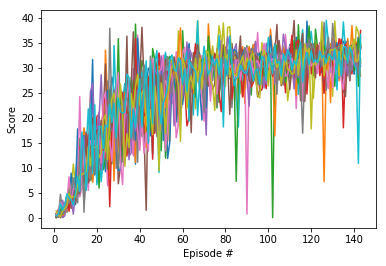

In [5]:
def ddpg(n_episodes=500, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        #restart env 
        env_itter = env.reset(train_mode=True)[brain_name] #note training = True here
        #grab state of agents
        state =env_itter.vector_observations
        agent.reset()
        score = np.zeros(len(env_itter.agents)) 
        
        for t in range(max_t):
            #select an action for each agent based off learned weights
            #put a 1 instead of i_episodes if you do not want to decay the noise param
            action = agent.act(state,i_episode,add_noise=True)
            #send agents into env
            env_itter = env.step(action)[brain_name]  
            
            #pull out env results
            rewards = env_itter.rewards                      
            dones = env_itter.local_done
            next_states =env_itter.vector_observations
            #train agents
            agent.step(state, action, rewards, next_states, dones)
            score += rewards      
            state = next_states 
            #check if any agents finished
            if np.any(dones):
                break 
    
        scores_deque.append(score)
        scores.append(score)

        print('\rEpisode {}\tAverage Score: {:.2f}\tMin Score: {:.2f}\tMax Score: {:.2f}\tEpisode score: {:.2f}'.format(i_episode, np.mean(scores_deque),np.min(scores_deque),np.max(scores_deque),np.mean(score)), end="")
        if i_episode % 5 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        
        if np.mean(scores_deque) >= 30.0:
            print('\nDone! Solved task in {} Episodes'.format(i_episode))
            torch.save(agent.actor_local.state_dict(), 'solved_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'solved_critic.pth')
            break
    
    return scores


scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

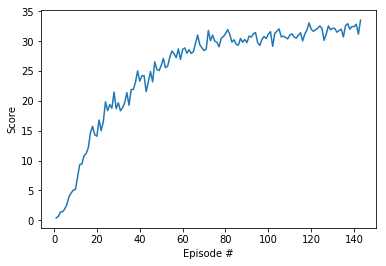

In [12]:
#lets look at the episode average score
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), np.mean(scores,axis=1))
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Great! we solved the env in 143 episodes.

The learning looks farily stable with this model arch and weighted noise approach.

Below are results from other iterations to understand how stable the learning is over a longer time horizon. 


### What happens when we remove the noise scaler like the origional paper does?

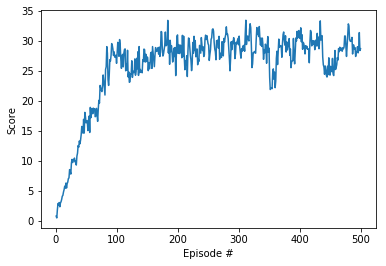

In [9]:
no_noise_scale = pd.read_csv('no_noise_scale_scores.csv',index_col=0)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(np.array(no_noise_scale))+1), np.mean(np.array(no_noise_scale),axis=1))
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Notice that learning is very stable in for this change, but the agents faile to get an average score >= 30 (it capped out at just over 29)

# Ideas for future work


I believe that further improvements can be made to the network architecture. For example, when I included batchnorm in between all layers of the network, the model struggled to learn at the same pace as the proposed solution. Further work on refining the architecture and network parameters will improve the results.

Adding prioritized experience replay might improve the algorithms learning. By sampling the largest error observations with higher priority, the network will be able to maximize the information gain for each learning step.

It would be interesting to see if an RNN architecture could improve the results. Capturing temporal dependencies among past actions could improve the agents ability to discern optimal actions at the current time step. Combining the actor network with a Bidirectional LSTM encoder/decoder architecture will be my next experiment!




